# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 10

**Author 1 (sciper):** Badr Larhdir (283205)  
**Author 2 (sciper):** Joe Najm (301560)   
**Author 3 (sciper):** Sébastien Jeanfavre (269551)   

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

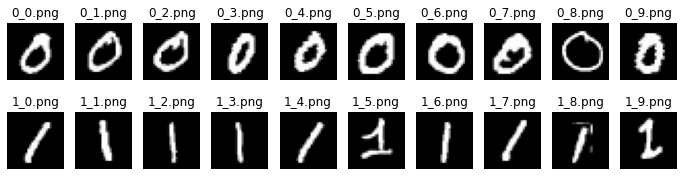

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [3]:
import cv2 as cv
import numpy as np
from skimage import measure
from skimage.morphology import opening

### 1.2 Fourier descriptors (15 pts)

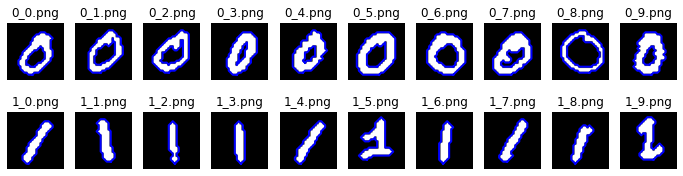

In [4]:
# We first open the images to get rid of the unwanted white pixels (like in the image 1_8) and keep only the number. 
# We then find the contours of the image and select the 2 first contours for the zeros (to keep the shape of zero) and the 
# first contour for the ones, as these contours are representing the shapes of the numbers.

zeros_preproc = []
ones_preproc = []

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    
    ret,im = cv.threshold(im,100,255,cv.THRESH_BINARY)
    contours = measure.find_contours(im, 0.5)
    zeros_preproc.append(im)
    ax.imshow(im, cmap='gray')
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2, c='blue')
    ax.plot(contours[1][:, 1], contours[1][:, 0], linewidth=2, c='blue')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):

    im = opening(im)
    ret,im = cv.threshold(im,20,255,cv.THRESH_BINARY)
    contours = measure.find_contours(im, 0.5)
    ones_preproc.append(im)
    ax.imshow(im, cmap='gray')
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2, c='blue')
    ax.axis('off')
    ax.set_title(nm)

In the function below, we define the fourier descriptor in a way that it is invariant to rotation, translation and scaling. First, we take the module of the coefficients because the rotational information is contained in the phase. This way, rotation invariance is ensured. To get translation invariance, we don't take the first fourier coefficient into account which only gives information about the starting point of the trajectory (contour). Lastly, we normalize in order to ensure scaling invariance.

In [5]:
def fourier_descriptor(contour, nb_coef1=1, nb_coef2=2):
    u_k = contour[:, 1] + 1j * (contour[:, 0])
    u_k_fft = np.abs(np.fft.fft(u_k))          
    norm = np.linalg.norm(u_k_fft[1:])         # We don't consider the first coeff to normalize 
                                               # to remain translation invariant
    return u_k_fft[nb_coef1]/norm, u_k_fft[nb_coef2]/norm

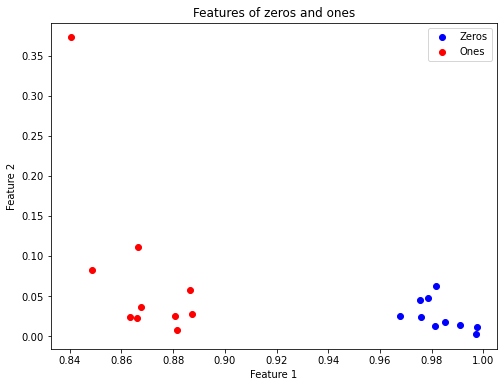

In [6]:
fig = plt.figure(figsize=(8, 6))

i=0
for zero in zeros_preproc:
    fft_1, fft_2 = fourier_descriptor(measure.find_contours(zero, 0.5)[0])
    plt.scatter(fft_1, fft_2, c='blue', label="Zeros" if i == 0 else "")
    i+= 1

i=0
for one in ones_preproc:
    fft_1, fft_2 = fourier_descriptor(measure.find_contours(one, 0.5)[0])
    plt.scatter(fft_1, fft_2, c='red', label="Ones" if i == 0 else "")
    i+=1
    
plt.title("Features of zeros and ones")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

We can see that the features are indeed linearly separable using the 2nd and 3rd fourier descriptors coefficients. We can draw a line in the middle of the plot to separate the zeros from the ones.

In [7]:
# Define functions returning random parameters to show invariance

# Translation
translation = lambda: np.random.rand(2)*40 - 20 # random translation in [-20, 20]

# Scale
scaling = lambda: np.random.rand() * 1.5 + 0.5 # random scaling factor in [0.5, 2]

# Rotation
def rotation():
    theta = 2*np.pi*np.random.rand() - np.pi # random angle in [-pi, pi]
    return np.array([[np.cos(theta), - np.sin(theta)], # rotation matrix
                     [np.sin(theta), np.cos(theta)]])

In [11]:
contours_zeros = [measure.find_contours(zero, 0.5)[0] for zero in zeros_preproc]
contours_ones = [measure.find_contours(one, 0.5)[0] for one in ones_preproc]

# We apply random transformation on the contour directly which is conceptualy equivalent to 
# transforming the original image. Doing so, we avoid inter-/extrapolation issue.
transformed_contours_zeros = [scaling() * c_zero @ rotation() + translation() for c_zero in contours_zeros]
transformed_contours_ones = [scaling() * c_one @ rotation() + translation() for c_one in contours_ones]


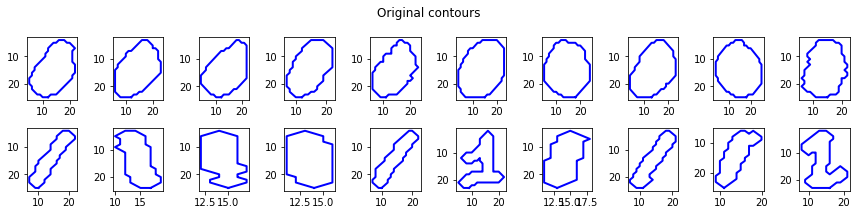

In [12]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, c_zero, nm in zip(axes[0], contours_zeros, zeros_names):
    ax.plot(c_zero[:, 1], c_zero[:, 0], linewidth=2, c='blue')
    ax.invert_yaxis()
    
for ax, c_one, nm in zip(axes[1], contours_ones, ones_names):
    ax.plot(c_one[:, 1], c_one[:, 0], linewidth=2, c='blue')
    ax.invert_yaxis()


fig.suptitle('Original contours')
plt.tight_layout()
plt.show()

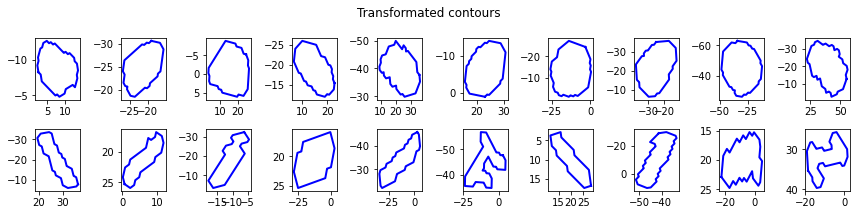

In [13]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))

for ax, c_zero, nm in zip(axes[0], transformed_contours_zeros, zeros_names):
    ax.plot(c_zero[:, 1], c_zero[:, 0], linewidth=2, c='blue')
    ax.invert_yaxis()

for ax, c_one, nm in zip(axes[1], transformed_contours_ones, ones_names):
    ax.plot(c_one[:, 1], c_one[:, 0], linewidth=2, c='blue')
    ax.invert_yaxis()

fig.suptitle('Transformated contours')
plt.tight_layout()
plt.show()

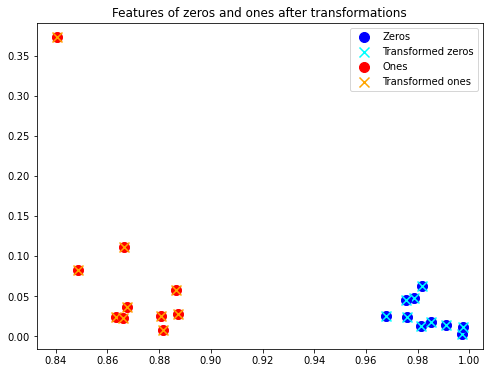

In [14]:
fig = plt.figure(figsize=(8, 6))
for i, (zero, zero_tr) in enumerate(zip(contours_zeros, transformed_contours_zeros)):
    fft_1, fft_2 = fourier_descriptor(zero)
    plt.scatter(fft_1, fft_2, s=100, c='blue', label="Zeros" if i == 0 else "")
    fft_1, fft_2 = fourier_descriptor(zero_tr)
    plt.scatter(fft_1, fft_2, s=100, c='cyan', marker='x', label="Transformed zeros" if i == 0 else "")

for i, (one, one_tr) in enumerate(zip(contours_ones, transformed_contours_ones)):
    fft_1, fft_2 = fourier_descriptor(one)
    plt.scatter(fft_1, fft_2, s=100, c='red', label="Ones" if i == 0 else "")
    fft_1, fft_2 = fourier_descriptor(one_tr)
    plt.scatter(fft_1, fft_2, s=100, c='orange', marker='x', label="Transformed ones" if i == 0 else "")

plt.title("Features of zeros and ones after transformations")
plt.legend()
plt.show()

We see that the transformations (translation, rotation and scaling) do not affect at all the descriptors as the features of the original and the transformed contours perfectly overlap.

### 1.3 Additional method (5 pts)

In [15]:
# Add your implementation and discussion

# We will perform dimensionality reduction using PCA
from sklearn.decomposition import PCA

# Instanciate PCA
pca = PCA(n_components=2)

# Build X from ones and zeros images
X_zeros = np.reshape(zeros_im, (10,-1))
X_ones = np.reshape(ones_im, (10,-1))

X = np.append(X_zeros, X_ones, axis=0)

# Fit the model
pca.fit(X)

PCA(n_components=2)

In [16]:
# Project the original vectorized images onto the new subspace of dimension 2
X_proj = pca.transform(X)

# Recover projected ones and zeros
zeros_pca = X_proj[:10]
ones_pca = X_proj[10:]

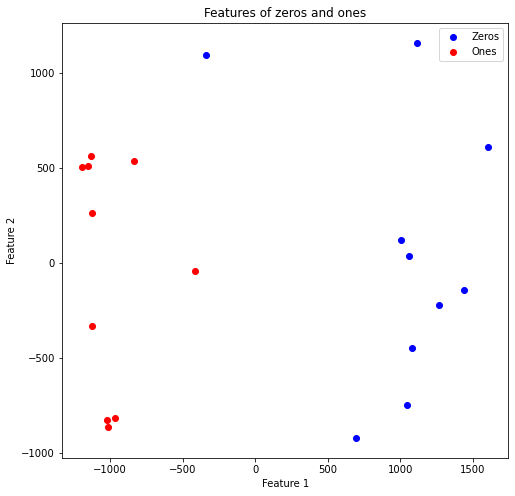

In [17]:
fig = plt.figure(figsize=(8, 8))

i=0
for zero in zeros_pca:
    pca_1, pca_2 = zero
    plt.scatter(pca_1, pca_2, c='blue', label="Zeros" if i == 0 else "")
    i+=1

i=0
for one in ones_pca:
    pca_1, pca_2 = one
    plt.scatter(pca_1, pca_2, c='red', label="Ones" if i == 0 else "")
    i+=1

plt.title("Features of zeros and ones")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

The data points are nicely separated as well. However, it seems that in this setting, the fourier descriptors lead to a better clustering of the data points.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

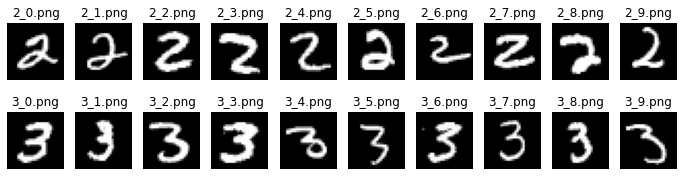

In [18]:
# Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

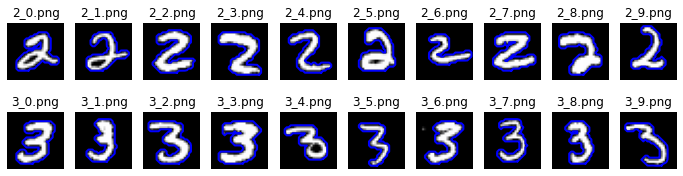

In [19]:
# Looking at the images, we do not need to open the images as we do not have any white parasite pixels. We apply the same method
# as before to extract and draw the contours.

from skimage.morphology import binary_closing, binary_opening, square

# Add your implementation and discussion
twos_preproc = []
threes_preproc = []

twos_opened = [binary_opening(im, square(1)) for im in twos_im]
threes_opened = [binary_opening(im, square(1)) for im in threes_im]

fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    
    contours = measure.find_contours(im, 0.5)
    twos_preproc.append(im)
    ax.imshow(im, cmap='gray')
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2, c='blue')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], threes_im, threes_names):

    contours = measure.find_contours(im, 0.5)
    threes_preproc.append(im)
    ax.imshow(im, cmap='gray')
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2, c='blue')
    ax.axis('off')
    ax.set_title(nm)

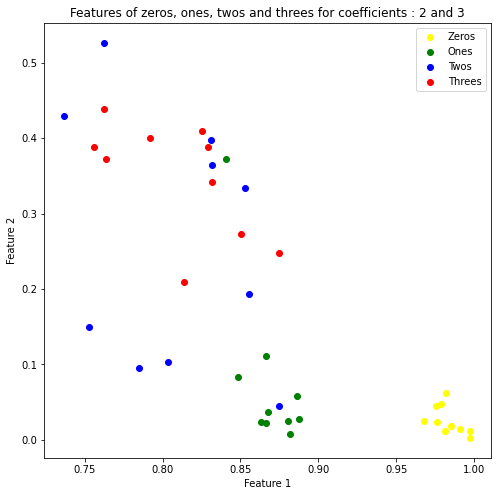

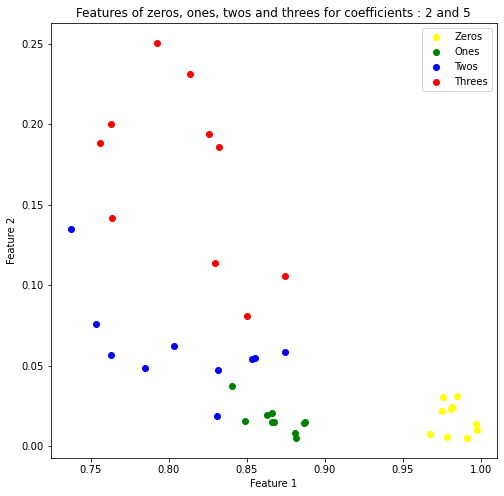

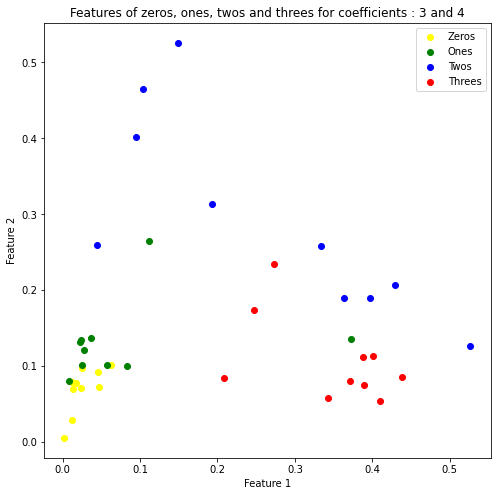

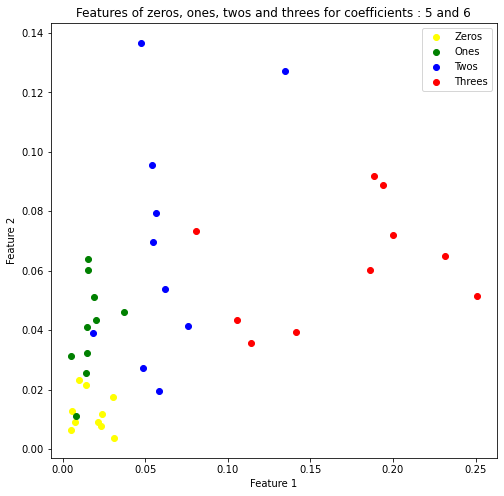

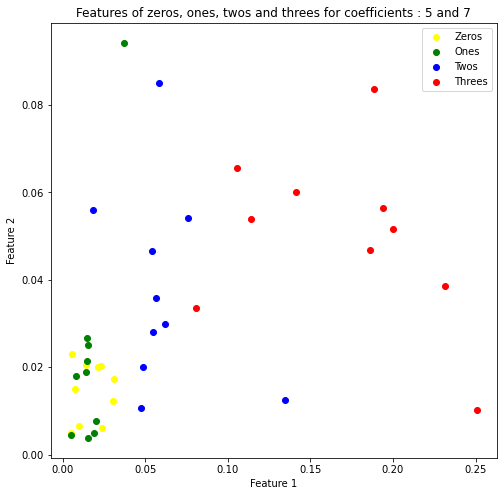

In [20]:
coefs_possible = [[1,2],[1,4],[2,3],[4,5],[4,6]]
for c in coefs_possible:
    c1 = c[0]
    c2 = c[1]

    fig = plt.figure(figsize=(8, 8))
    i=0
    for zero in zeros_preproc:
        fft_1, fft_2 = fourier_descriptor(measure.find_contours(zero, 0.5)[0],c1,c2)
        plt.scatter(fft_1, fft_2, c='yellow', label="Zeros" if i == 0 else "")
        i+=1
    i=0
    for one in ones_preproc:
        fft_1, fft_2 = fourier_descriptor(measure.find_contours(one, 0.5)[0],c1,c2)
        plt.scatter(fft_1, fft_2, c='green', label="Ones" if i == 0 else "")
        i+=1
    i=0
    for two in twos_preproc:
        fft_1, fft_2 = fourier_descriptor(measure.find_contours(two, 0.5)[0],c1,c2)
        plt.scatter(fft_1, fft_2, c='blue', label="Twos" if i == 0 else "")
        i+=1
    i=0
    for three in threes_preproc:
        fft_1, fft_2 = fourier_descriptor(measure.find_contours(three, 0.5)[0],c1,c2)
        plt.scatter(fft_1, fft_2, c='red', label="Threes" if i == 0 else "")
        i+=1

    
    plt.title(f"Features of zeros, ones, twos and threes for coefficients : {c1 + 1} and {c2 +1}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()


Looking at the feature plots, we notice that using the 2nd and 3rd coefficients of the fourier descriptor of the contour will not yield to separable data. Thus we tried with different coefficients and find that although they are not perfectly lineraly separable, it is possible to distinguish 2 different regions for the twos and the threes. The best coefficients seem to be the 2nd and the 5th.

We notice that is it quite hard to separate the zeros, ones, twos and threes using only 2 features. Although we get results that show some kind of separation, we would have hopped to get more separable and distinct clusters of data on the plots.